In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime                        
import matplotlib.pyplot as plt                    # plots
import seaborn as sns                              # more plots
from dateutil.relativedelta import relativedelta   # working with dates with style
from scipy.optimize import minimize                # for function minimization
import statsmodels.formula.api as smf              # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                      # some useful functions
from tqdm import tqdm_notebook
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from mlxtend.regressor import LinearRegression

In [2]:
df = pd.read_excel (r'C:\Users\u23e02\Downloads\Complete_Data.xlsx')
df['time'] = df['time'].astype('datetime64[ns]')
df.head()

,Unnamed: 0,time,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
0,0,2020-06-15 01:00:00,430,18.6,0,1.7,0.0,0,173,115,0.3,0.0,37.9,24.4
1,1,2020-06-15 01:30:00,564,20.2,0,1.9,0.0,0,189,157,0.3,0.0,42.3,24.8
2,2,2020-06-15 02:00:00,76,2.9,0,0.3,0.0,0,19,25,0.1,0.0,6.1,3.4
3,3,2020-06-15 04:00:00,427,16.1,0,1.4,3.2,0,108,132,0.4,0.0,28.0,19.1
4,4,2020-06-15 04:30:00,639,24.4,0,1.3,12.3,0,162,181,0.4,0.0,40.8,28.9


In [3]:
df = df.drop("Unnamed: 0", axis = 1)
df = df.set_index("time")

In [4]:
df3 = df.copy()
# df3 = df3.set_index("time")
print(df3.index.min())
print(df3.index.max())

2020-06-15 01:00:00
2020-06-26 23:30:00


In [5]:
df.head(2)

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
time,,,,,,,,,,,,
2020-06-15 01:00:00,430,18.6,0,1.7,0.0,0,173,115,0.3,0.0,37.9,24.4
2020-06-15 01:30:00,564,20.2,0,1.9,0.0,0,189,157,0.3,0.0,42.3,24.8


In [6]:
df.tail(2)

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
time,,,,,,,,,,,,
2020-06-26 23:00:00,278,19.0,0,0.0,0.0,0,43,118,0.0,0.0,0.0,5.2
2020-06-26 23:30:00,291,19.1,0,0.0,0.0,0,47,119,0.0,0.0,0.0,12.8


In [7]:
EM4 = df[['EM4']]
EM4.head()

,EM4
time,
2020-06-15 01:00:00,173
2020-06-15 01:30:00,189
2020-06-15 02:00:00,19
2020-06-15 04:00:00,108
2020-06-15 04:30:00,162


# Anomilies Detection

In [8]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.645, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend", lw = 3)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond", lw = 2)
        plt.plot(lower_bond, "r--", lw = 2)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", lw = 3)
    plt.legend(loc="upper left")
    plt.grid(True)

In [10]:
energy_anomaly = pd.DataFrame(EM4['EM4'].copy())
# energy_anomaly.iloc[-20] = energy_anomaly.iloc[-20] * 0.2 # say we have 80% drop of energy 
# plotMovingAverage(energy_anomaly, 5, plot_intervals=True, plot_anomalies=True)

# Removing Only the anomalies

In [11]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
data2 = EM4.copy()
energy_anomaly = pd.DataFrame(data2['EM4'])
rolling_mean = energy_anomaly.rolling(window=5).mean()
mae = mean_absolute_error(energy_anomaly[5:], rolling_mean[5:])
deviation = np.std(energy_anomaly[5:] - rolling_mean[5:])
lower_bond = rolling_mean - (mae + 1.645 * deviation)
upper_bond = rolling_mean + (mae + 1.645 * deviation)
anomalies = pd.DataFrame(index = energy_anomaly.index, columns = energy_anomaly.columns)
anomalies[energy_anomaly<lower_bond] = energy_anomaly[energy_anomaly<lower_bond]
anomalies[energy_anomaly>upper_bond] = energy_anomaly[energy_anomaly>upper_bond]
anomalies = anomalies.dropna()

In [13]:
data2.loc[anomalies.index,'EM4'] = np.nan 

In [14]:
# For Anomalies
# Linear Interpolation
new1_data2 = data2.interpolate()
# new1_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

In [15]:
# For Anomalies
# Time Interpolation
new2_data2 = data2.interpolate(method = 'time')
# new2_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

In [16]:
# For Anomalies
# Cubic Interpolation
new3_data2 = data2.interpolate(method = 'cubic')
# new3_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

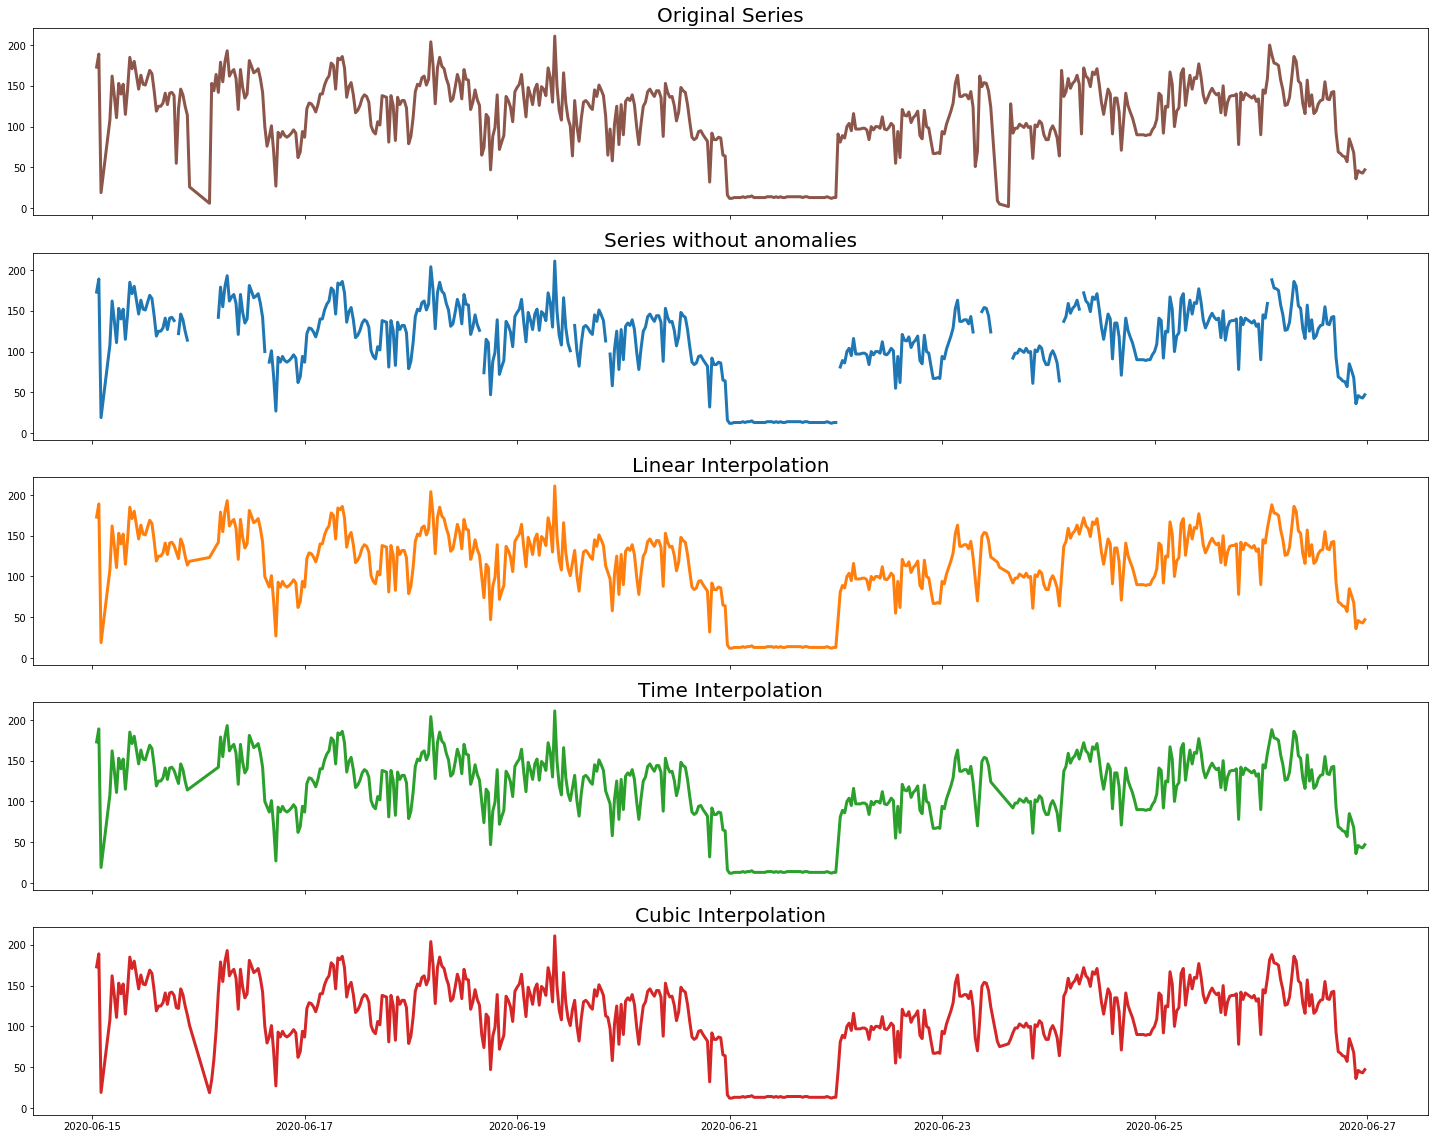

In [17]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, gridspec_kw={'hspace': 0.2}, figsize=(25,20))
# fig.suptitle('Interpolated Series', va = 'bottom', ha = 'center', fontsize = 50)
axs[0].plot(EM4.index, EM4['EM4'], 'tab:brown', linewidth = 3)
axs[0].set_title('Original Series', fontsize = 20)
axs[1].plot(data2.index, data2['EM4'], 'tab:blue', linewidth = 3)
axs[1].set_title('Series without anomalies', fontsize = 20)
axs[2].plot(new1_data2.index, new1_data2['EM4'], 'tab:orange', linewidth = 3)
axs[2].set_title('Linear Interpolation', fontsize = 20)
axs[3].plot(new2_data2.index, new2_data2['EM4'], 'tab:green', linewidth = 3)
axs[3].set_title('Time Interpolation', fontsize = 20)
axs[4].plot(new3_data2.index, new3_data2['EM4'], 'tab:red', linewidth = 3)
axs[4].set_title('Cubic Interpolation', fontsize = 20)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [18]:
# Linear Interpolation
from statsmodels.tsa.stattools import adfuller
result_o = adfuller(EM4['EM4'])
result_l = adfuller(new1_data2['EM4'])
result_t = adfuller(new2_data2['EM4'])
result_c = adfuller(new3_data2['EM4'])

In [19]:
P_value = [result_o[1], result_l[1], result_t[1], result_c[1]]
ADF_Statistics = [result_o[0], result_l[0], result_t[0], result_c[0]]
Result = pd.DataFrame(P_value, ADF_Statistics).reset_index()
Result = Result.rename(columns={'index': 'ADF Statistics', 0: 'P-Value'})
Result = Result.T
Result = Result.rename(columns={0: 'Original', 1: 'Linear', 2: 'Time', 3: 'Cubic'})
Result

,Original,Linear,Time,Cubic
ADF Statistics,-3.757223,-3.146991,-3.141784,-3.577304
P-Value,0.003377,0.023265,0.023612,0.006210


# Time Series to Supervised Learning 

In [20]:
from pandas import DataFrame
df = EM4.copy()
df.head()

,EM4
time,
2020-06-15 01:00:00,173
2020-06-15 01:30:00,189
2020-06-15 02:00:00,19
2020-06-15 04:00:00,108
2020-06-15 04:30:00,162


In [21]:
# df['EM4(t-1)'] = df['EM4'].shift(1)
# print(df)

In [22]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
#     n_vars = 1 if type(data) is list else data.shape[1]
    n_vars = 1 
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('T%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('T%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('T%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
values = list(df['EM4'])
data = series_to_supervised(values, 15)
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [24]:
# list(data.columns)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

X = data.drop('T1(t)', axis=1)
Y=data[['T1(t)']]

X_train,X_test, y_train,y_test = train_test_split(X , Y, random_state=20, test_size=0.1)


# Model initialization
regression_model = LinearRegression()

# Fit the data(train the model)
regression_model.fit(X_train, y_train)

y_predicted = regression_model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)


# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[-0.038383    0.02707182  0.02551786  0.01268144 -0.0780079   0.02008705
   0.05589569 -0.00986484  0.03040612  0.00745304  0.05358763  0.05071657
   0.02625772  0.07541548  0.65001159]]
Intercept: [9.68485803]
Root mean squared error:  597.3646106283444
R2 score:  0.7489219306353383


In [26]:
X_train

,T1(t-15),T1(t-14),T1(t-13),T1(t-12),T1(t-11),T1(t-10),T1(t-9),T1(t-8),T1(t-7),T1(t-6),T1(t-5),T1(t-4),T1(t-3),T1(t-2),T1(t-1)
538,136.0,160.0,186.0,180.0,156.0,153.0,128.0,116.0,157.0,125.0,139.0,116.0,119.0,128.0,132.0
374,114.0,119.0,89.0,85.0,120.0,100.0,98.0,82.0,67.0,67.0,68.0,67.0,94.0,91.0,103.0
516,142.0,133.0,141.0,139.0,137.0,135.0,138.0,131.0,134.0,90.0,145.0,141.0,159.0,200.0,188.0
375,119.0,89.0,85.0,120.0,100.0,98.0,82.0,67.0,67.0,68.0,67.0,94.0,91.0,103.0,111.0
271,127.0,106.0,87.0,84.0,86.0,94.0,95.0,90.0,86.0,82.0,32.0,92.0,84.0,84.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,138.0,113.0,65.0,97.0,58.0,103.0,125.0,78.0,127.0,90.0,131.0,135.0,132.0,139.0,127.0
238,103.0,125.0,78.0,127.0,90.0,131.0,135.0,132.0,139.0,127.0,100.0,78.0,104.0,125.0,130.0
286,86.0,65.0,64.0,16.0,12.0,12.0,13.0,13.0,13.0,13.0,14.0,13.0,14.0,14.0,15.0
489,165.0,171.0,126.0,146.0,163.0,146.0,160.0,159.0,177.0,161.0,139.0,129.0,135.0,142.0,147.0


In [27]:
len(y_predicted)

55

In [28]:
len(data)

543